<a href="https://colab.research.google.com/github/mzfarhan/geospatial-sentiment-analysis-indomaret/blob/main/Indomaret_Store_Location_Analysis_in_Jakarta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting and Visualizing Indomaret Location Data in Jakarta Using Google Places API

This is a Google Colab notebook that will be used to retrieve Indomaret location data from the Google Places API for five areas in Jakarta (West, Central, South, East, and North Jakarta). After the data is collected, it will be processed and several visualizations will be created to understand its distribution.

In [ ]:
# Install necessary libraries
!pip install googlemaps pandas matplotlib seaborn folium TextBlob

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40714 sha256=c46f36f7196a3cf6488352a0f20e8038acdfa976a21ec5ce0db9829b84fb9e80
  Stored in directory: /root/.cache/pip/wheels/f1/09/77/3cc2f5659cbc62341b30f806aca2b25e6a26c351daa5b1f49a
Successfully built googlemaps


In [ ]:
import googlemaps
import pandas as pd
import time
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
import json
from textblob import TextBlob

# Replace with your actual Google Places API key
# Make sure your API Key has access to the Google Places API and billing is enabled if necessary
API_KEY = 'Insert API Key here'
gmaps = googlemaps.Client(key=API_KEY)

print("Libraries imported successfully and Google Maps API connection established")

Libraries imported successfully and Google Maps API connection established


## Indomaret Location Data Collection Strategy

Define the list of Jakarta regions to be searched. For each region, a search for 'Indomaret in [Region Name]' will be conducted.

**Important Note on API Limitations:**
The Google Places API by default returns up to 20 results per request. To retrieve more results, the `next_page_token` must be used to fetch the next page of results. In this code, up to 3 pages will be retrieved (a maximum of 60 unique results per region) to ensure better coverage, with a 2-second delay between requests to avoid rate limiting.

In [ ]:
regency_city = [
    "West Jakarta",
    "Central Jakarta",
    "South Jakarta",
    "East Jakarta",
    "North Jakarta"
]

all_indomaret_data = []

print("Starting Indomaret data collection...")

for city in regency_city:
    query = f"Indomaret in {city}"
    print(f"\nSearching for '{query}'...")

    try:
        # Ambil halaman pertama
        places_result = gmaps.places(query=query)
        for place in places_result.get('results', []):
            place['search_area'] = city # Add search area column for identification
            all_indomaret_data.append(place)
        print(f"Found {len(places_result.get('results', []))} results on page 1 for {city}")

        # Try to get the next page if available (up to 2 more pages)
        next_page_token = places_result.get('next_page_token')
        page_count = 1
        while next_page_token and page_count < 3: # Get up to 3 pages
            time.sleep(2) # Pause to avoid API rate limit
            places_result = gmaps.places(query=query, page_token=next_page_token)
            for place in places_result.get('results', []):
                place['search_area'] = city
                all_indomaret_data.append(place)
            print(f"Found {len(places_result.get('results', []))} results on page {page_count+1} for {city}")
            next_page_token = places_result.get('next_page_token')
            page_count += 1

    except Exception as e:
        print(f"An error occurred while searching for {city}: {e}")

print(f"\nTotal Indomaret locations collected (including duplicates): {len(all_indomaret_data)}.")

Starting Indomaret data collection...

Searching for 'Indomaret in West Jakarta'...
Found 20 results on page 1 for West Jakarta
Found 20 results on page 2 for West Jakarta
Found 20 results on page 3 for West Jakarta

Searching for 'Indomaret in Central Jakarta'...
Found 20 results on page 1 for Central Jakarta
Found 20 results on page 2 for Central Jakarta
Found 20 results on page 3 for Central Jakarta

Searching for 'Indomaret in South Jakarta'...
Found 20 results on page 1 for South Jakarta
Found 20 results on page 2 for South Jakarta
Found 20 results on page 3 for South Jakarta

Searching for 'Indomaret in East Jakarta'...
Found 20 results on page 1 for East Jakarta
Found 20 results on page 2 for East Jakarta
Found 20 results on page 3 for East Jakarta

Searching for 'Indomaret in North Jakarta'...
Found 20 results on page 1 for North Jakarta
Found 20 results on page 2 for North Jakarta
Found 20 results on page 3 for North Jakarta

Total Indomaret locations collected (including dupl

In [ ]:
# Extract relevant information and process into a DataFrame
processed_data = []
for place in all_indomaret_data:
    name = place.get('name')
    address = place.get('formatted_address')
    latitude = place['geometry']['location']['lat']
    longitude = place['geometry']['location']['lng']
    rating = place.get('rating')
    user_ratings_total = place.get('user_ratings_total')
    place_id = place.get('place_id')
    search_area = place.get('search_area') # Get the search area

    processed_data.append({
        'Name': name,
        'Address': address,
        'Latitude': latitude,
        'Longitude': longitude,
        'Rating': rating,
        'Total Review': user_ratings_total,
        'Place ID': place_id,
        'Search Area': search_area
    })

df = pd.DataFrame(processed_data)

# Remove duplicates based on 'Place ID' as one location can appear in multiple search results
df.drop_duplicates(subset='Place ID', inplace=True)

# Filter for Indomaret locations that have a rating (and at least 1 review to ensure review data exists)
df_with_ratings = df.dropna(subset=['Rating', 'Total Review'])
df_with_ratings = df_with_ratings[df_with_ratings['Total Review'] > 0].copy()


print("Indomaret Data (first 5 rows after cleaning duplicates):")
print(df.head())
print(f"\nTotal unique Indomaret locations found: {len(df)}")
print(f"Total Indomaret locations with rating and review data (>0): {len(df_with_ratings)}")

Indomaret Data (first 5 rows after cleaning duplicates):
                                   Name  \
0  Indomaret Panjang Raya 5A Drive Thru   
1               Indomaret Tanjung Duren   
2               Indomaret Daan Mogot 30   
3          Indomaret Jalan Panjang TPDH   
4              Indomaret Daan Mogot 116   

                                             Address  Latitude   Longitude  \
0  Jl. Panjang No.5, RT.5/RW.10, Kb. Jeruk, Kec. ... -6.195228  106.768603   
1  Jl. Tanjung Duren Raya No.17 1, RT.1/RW.5, Tj.... -6.173919  106.785738   
2  RQR5+XRP, RT.13/RW.3, Kedaung Kali Angke, Ceng... -6.157403  106.759597   
3  Jl. Panjang Arteri Klp. Dua Raya No.10, RT.8/R... -6.202780  106.769670   
4  Daan Mogot Rd No.116, RT.4/RW.2, Wijaya Kusuma... -6.164441  106.778605   

   Rating  Total Review                     Place ID   Search Area  
0     4.6          1125  ChIJUR1GSdj3aS4RQigDgcle7AA  West Jakarta  
1     4.3           188  ChIJicSBMSD3aS4R5MuW-iHP_aI  West Jakarta  
2     4.

### Collecting Reviews and Analyzing Sentiment

In [ ]:
all_reviews = []
sentiment_results = []
review_count = 0

print("\nStarting review collection and sentiment analysis...")

# Loop through each unique Indomaret
for index, row in df.iterrows():
    place_id = row['Place ID']
    name = row['Name']
    area = row['Search Area']

    try:
        # Get place details, including reviews
        # Note: The API may only return a few top reviews
        place_details = gmaps.place(place_id=place_id, fields=['name', 'review'])
        reviews = place_details.get('result', {}).get('reviews', [])

        for review in reviews:
            text = review.get('text', '')
            if text:
                analysis = TextBlob(text)
                # Polarity is between -1.0 (negative) and 1.0 (positive)
                # Subjectivity is between 0.0 (factual) and 1.0 (opinion)

                sentiment = 'Neutral'
                if analysis.sentiment.polarity > 0.1: # Threshold for positive
                    sentiment = 'Positive'
                elif analysis.sentiment.polarity < -0.1: # Threshold for negative
                    sentiment = 'Negative'

                all_reviews.append({
                    'Place ID': place_id,
                    'Indomaret Name': name,
                    'Area': area,
                    'Teks Review': text,
                    'Sentiment': sentiment,
                    'Polarity': analysis.sentiment.polarity,
                    'Subjectivity': analysis.sentiment.subjectivity
                })
                review_count += 1
        time.sleep(0.5) # Pause to avoid API Details rate limit

    except Exception as e:
        print(f"Failed to get reviews for {name} (Place ID: {place_id}): {e}")

df_reviews = pd.DataFrame(all_reviews)

print(f"\nTotal {review_count} reviews collected and analyzed")
print("\nReviews DataFrame (first 5 rows):")
print(df_reviews.head())


Starting review collection and sentiment analysis...

Total 1363 reviews collected and analyzed

Reviews DataFrame (first 5 rows):
                      Place ID                        Indomaret Name  \
0  ChIJUR1GSdj3aS4RQigDgcle7AA  Indomaret Panjang Raya 5A Drive Thru   
1  ChIJUR1GSdj3aS4RQigDgcle7AA  Indomaret Panjang Raya 5A Drive Thru   
2  ChIJUR1GSdj3aS4RQigDgcle7AA  Indomaret Panjang Raya 5A Drive Thru   
3  ChIJUR1GSdj3aS4RQigDgcle7AA  Indomaret Panjang Raya 5A Drive Thru   
4  ChIJUR1GSdj3aS4RQigDgcle7AA  Indomaret Panjang Raya 5A Drive Thru   

           Area                                        Teks Review Sentiment  \
0  West Jakarta  strategic location, complete choice for conven...   Neutral   
1  West Jakarta  I think this is the first indomaret drive thru...  Positive   
2  West Jakarta  Like 5 star Indomart with coffee shop inside a...  Positive   
3  West Jakarta  Indomaret Panjang Raya 5A is strategically loc...  Positive   
4  West Jakarta  Indomaret jalan pa

## Presenting Results in Data Visualizations

Visualize the collected Indomaret data to gain further insights into its distribution in Jakarta.

### Interactive Map Using Folium

In [ ]:
# Determine the center of the map (average coordinates of the found Indomaret locations in Jakarta)
jakarta_center_lat = df['Latitude'].mean()
jakarta_center_lon = df['Longitude'].mean()

# Initialize the Folium map
m = folium.Map(location=[jakarta_center_lat, jakarta_center_lon], zoom_start=11)

# Add a MarkerCluster to group the markers
marker_cluster = MarkerCluster().add_to(m)

# Add each Indomaret location as a marker
for idx, row in df.iterrows():
    popup_text = f"<b>{row['Name']}</b><br>" \
                 f"Address: {row['Address']}<br>" \
                 f"Rating: {row['Rating'] if pd.notnull(row['Rating']) else 'N/A'} " \
                 f"({row['Total Review'] if pd.notnull(row['Total Review']) else 0} review)"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='info-sign') # Use a red icon for Indomaret
    ).add_to(marker_cluster)

print("The Interactive Indomaret Map will appear below:")
# Display the peta
m

The Interactive Indomaret Map will appear below:


### Bar Chart of the Number of Indomaret Stores per Area

/tmp/ipython-input-12-802636734.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='Search Area', data=df, order=df['Search Area'].value_counts().index, palette='viridis')


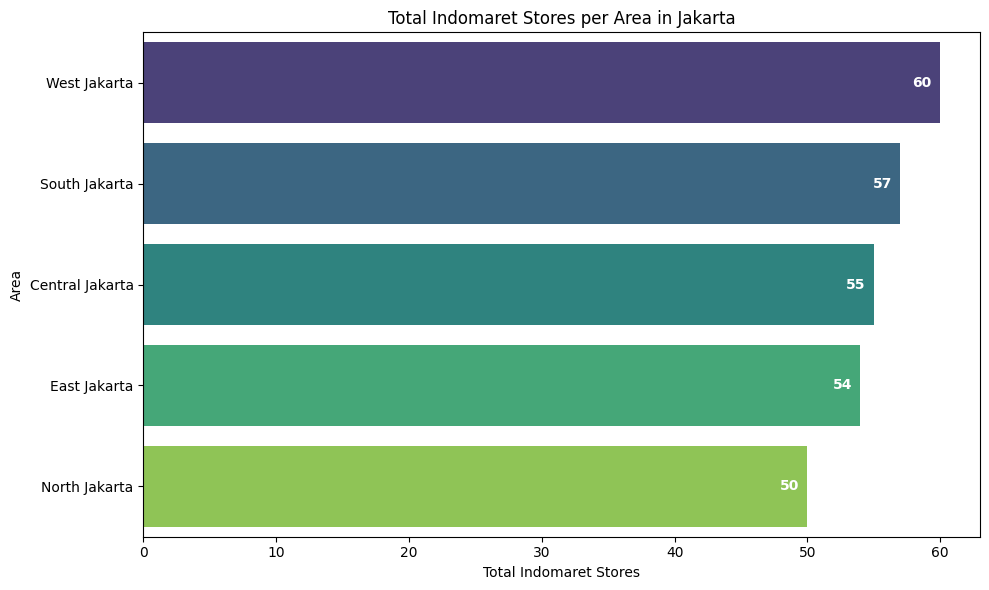

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Search Area', data=df, order=df['Search Area'].value_counts().index, palette='viridis')
plt.title('Total Indomaret Stores per Area in Jakarta')
plt.xlabel('Total Indomaret Stores')
plt.ylabel('Area')
plt.tight_layout()

# Add annotations to the bar chart
for container in ax.containers:
    # Set the annotation position at the right end inside the bar
    ax.bar_label(container, fmt='%d', color='white', fontweight='bold', label_type='edge', padding=-20)

plt.show()

### Store Quantity and Rating Standards

Visualization of the proportion of Indomaret stores with a rating above 4.0.

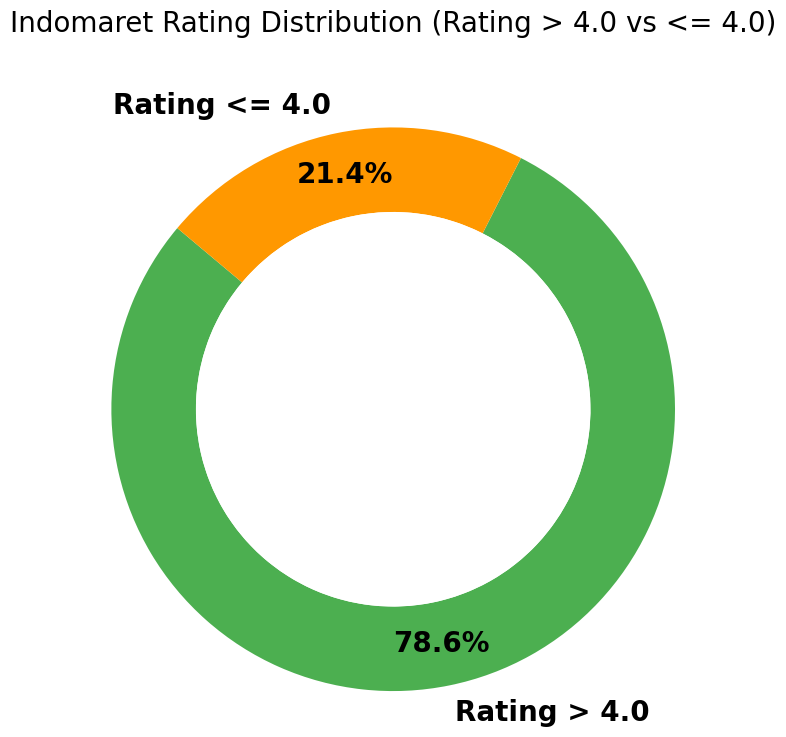

In [ ]:
# Define the rating threshold
rating_threshold = 4.0

# Count the number of Indomaret stores with ratings above and below the threshold
# Using df_with_ratings as it's already filtered to have ratings and > 0 reviews
count_above_threshold = df_with_ratings[df_with_ratings['Rating'] > rating_threshold].shape[0]
count_below_threshold = df_with_ratings.shape[0] - count_above_threshold

# Create data for the donut chart
labels = [f'Rating > {rating_threshold}', f'Rating <= {rating_threshold}']
sizes = [count_above_threshold, count_below_threshold]
colors = ['#4CAF50', '#FF9800'] # Green for high ratings, Orange for low/equal ratings

# Calculate percentages
total_rated_indomaret = df_with_ratings.shape[0]
percentages = [(count / total_rated_indomaret) * 100 for count in sizes]

# Create the donut chart plot
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.3), pctdistance=0.85) # pctdistance moves autopct inside

# Set the font weight to 'bold' and color to black for the percentage annotations (autopct)
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_color('black')
    autotext.set_fontsize(20) # Set the percentage font size

# Set the font weight to 'bold' and color to black for the text labels (labels)
for text in texts:
    text.set_fontweight('bold')
    text.set_color('black')
    text.set_fontsize(20) # Set the label font size

# Add a title with padding
plt.title(f'Indomaret Rating Distribution (Rating > {rating_threshold} vs <= {rating_threshold})', pad=50, fontsize=20)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')

plt.show()

### Histogram/KDE Plot of Indomaret Rating Distribution

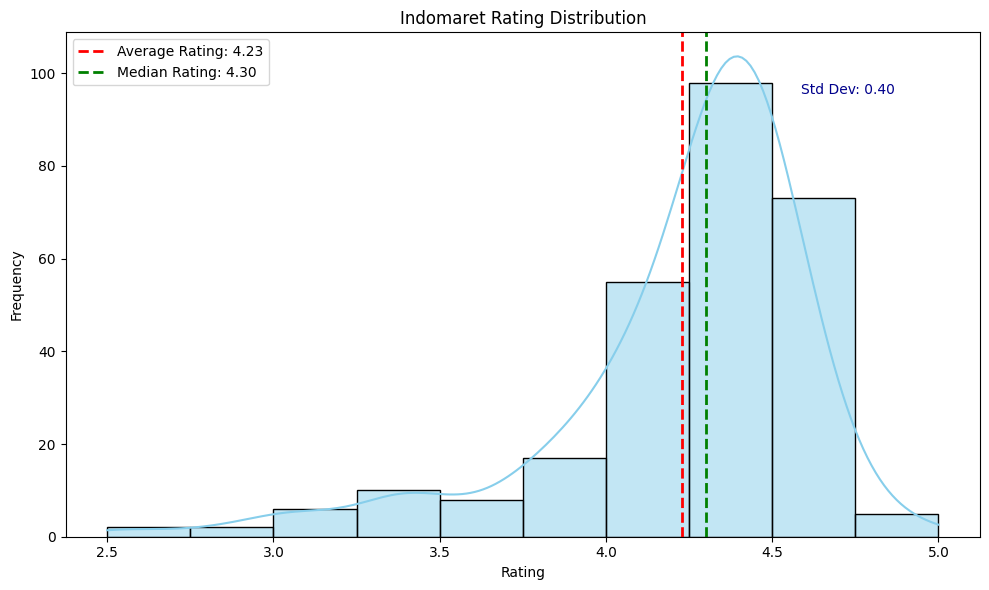

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(df['Rating'].dropna(), bins=10, kde=True, color='skyblue')
plt.title('Indomaret Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(False)

# Add the average rating as a vertical line
mean_rating = df['Rating'].mean()
plt.axvline(mean_rating, color='red', linestyle='dashed', linewidth=2, label=f'Average Rating: {mean_rating:.2f}')

# Add the median rating as a vertical line
median_rating = df['Rating'].median()
plt.axvline(median_rating, color='green', linestyle='dashed', linewidth=2, label=f'Median Rating: {median_rating:.2f}')

# Add the standard deviation as a text annotation
std_rating = df['Rating'].std()
# Determine the annotation position (e.g., in the top right corner)
# Adjust the x and y coordinates as needed to avoid covering the graph
plt.text(ax.get_xlim()[1] * 0.95, ax.get_ylim()[1] * 0.9, f'Std Dev: {std_rating:.2f}',
         fontsize=10, color='darkblue', ha='right', va='top')

plt.legend()

plt.show()

### Scatter Plot Rating vs Total Review

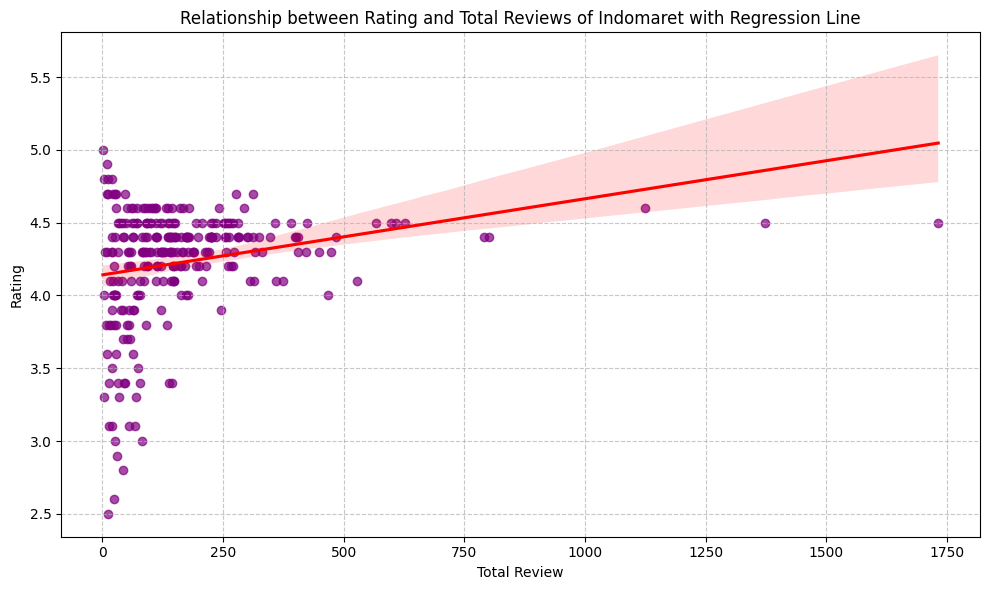

In [ ]:
plt.figure(figsize=(10, 6))
# Using regplot to add a regression line
sns.regplot(x='Total Review', y='Rating', data=df.dropna(subset=['Rating', 'Total Review']),
            scatter_kws={'alpha':0.7, 'color':'purple'}, line_kws={'color':'red'})
plt.title('Relationship between Rating and Total Reviews of Indomaret with Regression Line')
plt.xlabel('Total Review')
plt.ylabel('Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Sentiment Review Distribution Visualization

/tmp/ipython-input-11-3286238069.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Sentiment', data=df_reviews, order=['Positive', 'Neutral', 'Negative'], palette='viridis')


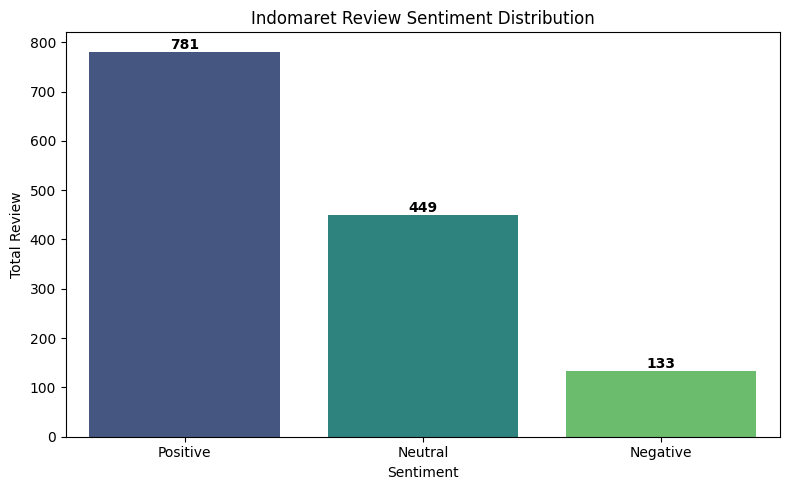

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Sentiment', data=df_reviews, order=['Positive', 'Neutral', 'Negative'], palette='viridis')
plt.title('Indomaret Review Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Total Review')
plt.tight_layout()

# Add annotations to the sentiment bar chart
for container in ax.containers:
    # Set the annotation position inside the bar, slightly above the center
    ax.bar_label(container, fmt='%d', color='black', fontweight='bold', label_type='edge')

plt.show()

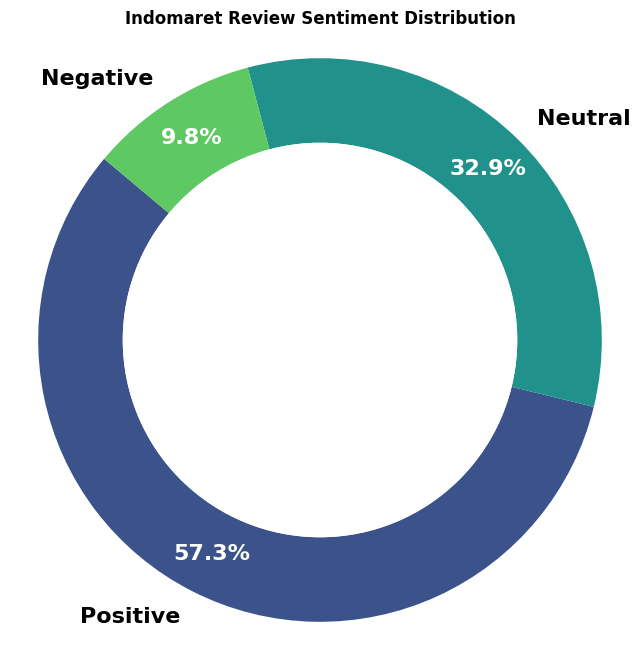

In [ ]:
# Calculate the number of reviews per sentiment
sentiment_counts = df_reviews['Sentiment'].value_counts()

# Define the sentiment order
order = ['Positive', 'Neutral', 'Negative']
sentiment_counts = sentiment_counts.reindex(order)

# Calculate the percentage
total_review = sentiment_counts.sum()
percentages = (sentiment_counts / total_review) * 100

# Create a donut chart plot
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(sentiment_counts)), pctdistance=0.85, wedgeprops=dict(width=0.3))

# Set the font weight to 'bold' and the font size to 16 for the text labels
for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(16)

# Set the font weight to 'bold' and the font size to 16 for the percentage annotations (autopct)
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(16)
    autotext.set_color('white')

# Add title
plt.title('Indomaret Review Sentiment Distribution', fontweight='bold')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')

plt.show()

### Best Rating Analysis

Identify the Indomaret with the highest rating in each region of Jakarta, as well as the overall best-rated Indomaret from the collected data. To ensure the quality of the ratings, only Indomaret locations with at least a few reviews (e.g., a minimum of 5 reviews) will be considered.

In [ ]:
# Filter the data for Indomaret locations that have a rating and at least 5 reviews (to ensure more credible ratings)
min_review_top_rating = 5
df_filtered_ratings = df_with_ratings[df_with_ratings['Total Review'] >= min_review_top_rating].copy()

if df_filtered_ratings.empty:
    print(f"\nNo Indomaret has a rating and at least {min_review_top_rating} reviews found for top rating analysis")
else:
    print(f"\n--- Top 5 Highest-Rated Indomaret per Region (minimum {min_review_top_rating} reviews) ---")
    for area in regency_city:
        print(f"\n--- {area} ---")
        top_5_per_area = df_filtered_ratings[df_filtered_ratings['Search Area'] == area]\
                            .sort_values(by='Rating', ascending=False)\
                            .head(5)
        if not top_5_per_area.empty:
            for idx, row in top_5_per_area.iterrows():
                total_review_display = int(row['Total Review']) if pd.notnull(row['Total Review']) else 'N/A'
                print(f"  - {row['Name']} (Rating: {row['Rating']}, Review: {total_review_display})")
        else:
            print("  No Indomaret data with ratings and reviews in this area meets the criteria")

    print("\n--- Best Overall Rated Indomaret (minimum 5 reviews) ---")
    # Sort by rating and then by total reviews (if ratings are the same)
    best_overall_rating = df_filtered_ratings.sort_values(by=['Rating', 'Total Review'], ascending=[False, False]).head(1)
    if not best_overall_rating.empty:
        for idx, row in best_overall_rating.iterrows():
            print(f"Name: {row['Name']}")
            print(f"Address: {row['Address']}")
            print(f"Area: {row['Search Area']}")
            print(f"Rating: {row['Rating']}")
            print(f"Total Review: {int(row['Total Review'])}")
    else:
        print("No overall best-rated Indomaret meets the criteria")


--- Top 5 Highest-Rated Indomaret per Region (minimum 5 reviews) ---

--- West Jakarta ---
  - Indomaret Grand Surya (Rating: 4.8, Review: 19)
  - Indomaret Fresh (Rating: 4.7, Review: 313)
  - Indomaret Convinience Store (Rating: 4.7, Review: 29)
  - Indomaret Fresh Tomang raya 40 (Rating: 4.6, Review: 28)
  - Indomaret | Kebon Jeruk (Rating: 4.6, Review: 136)

--- Central Jakarta ---
  - Indomaret Fresh Central Park Grab Shellter. (Rating: 4.7, Review: 9)
  - Indomaret Ketapang Kemayoran TC52 (Rating: 4.7, Review: 12)
  - Indomaret Thamrin Boulevard (Rating: 4.7, Review: 27)
  - Indomaret Angkasa RA-1 (Rating: 4.6, Review: 105)
  - Indomaret Bendungan Walahar (Rating: 4.6, Review: 100)

--- South Jakarta ---
  - Indomaret Menara Kuningan (Rating: 4.9, Review: 10)
  - Indomaret Swadarma 3 (Rating: 4.8, Review: 12)
  - Indomaret | Kalibata - Kota Jakarta Selatan (Rating: 4.7, Review: 22)
  - Indomaret Panglima Polim 106 (Rating: 4.6, Review: 50)
  - Indomaret Nangka 1 (Rating: 4.6, Re

## Summary

From the visualization and analysis of Indomaret data in Jakarta, we gained several key insights:

*   **Geographical Distribution and Count per Region:** The interactive map displays the distribution of Indomaret locations across the five regions of Jakarta. Based on the unique data collected after removing duplicates (a total of 276 unique locations), the bar chart shows the distribution of Indomaret counts per region. Specifically, **West Jakarta (60), South Jakarta (57), Central Jakarta (55), East Jakarta (54), and North Jakarta (50) have unique Indomaret locations**. These differences are likely influenced by API data retrieval limitations and potential duplication.

*   **Rating Distribution:** The rating histogram shows the spread of customer ratings for Indomaret locations that have both a rating and more than 0 total reviews. This visualization shows that most ratings are concentrated at the higher end. The average rating from the collected data is **4.23**, and the median rating is **4.30**. These numbers indicate that overall, customers give fairly good ratings to Indomaret in Jakarta based on the available reviews.

*   **Relationship Between Rating and Total Reviews:** The scatter plot visualizes the relationship between the average rating of Indomaret stores and the total number of reviews received. Each point in the plot represents one Indomaret location. This plot helps us observe whether there is a tendency for Indomaret stores with more reviews to have higher or lower ratings, or whether the relationship is weak. The regression line in the plot attempts to capture the general trend in this data. A visual analysis of the plot can reveal whether most points are randomly distributed or clustered in certain areas (e.g., high ratings with many reviews, or low ratings with few reviews).

*   **Sentiment Distribution of Reviews:** The sentiment distribution bar chart shows the proportion of reviews categorized as Positive, Neutral, and Negative based on sentiment analysis of the translated review texts. From a **total of 1,363 reviews** analyzed, there are **781 Positive reviews**, **449 Neutral reviews**, and **133 Negative reviews**. This shows that the majority of collected reviews carry a positive sentiment.

*   **Best Rating Analysis:** Based on the analysis of Indomaret stores with a minimum of 5 reviews, we can identify top-performing stores in each region. Overall, the best-rated Indomaret is **Indomaret Menara Kuningan** with a rating of **4.9**, located at **6, Jl. Denpasar No.7, RT.6/RW.7, Kuningan, Karet Kuningan, Kecamatan Setiabudi, Kota Jakarta Selatan, Daerah Khusus Ibukota Jakarta 12940, Indonesia**, in the **South Jakarta** region, with a total of **10** reviews.

**Note:** The number of collected locations and reviews is influenced by the limitations of the Google Places API and the definition of the search area used.

# Sentiment Analysis of Indomaret in Jakarta Based on Reviews from Google Maps

## Average Sentiment per City in Jakarta


In [ ]:
average_sentiment_per_region = df_reviews.groupby('Area')['Polarity'].mean()
print("Average Sentiment Polarity (a measure of emotional orientation) per city in Jakarta:")
print(average_sentiment_per_region)

Average Sentiment Polarity (a measure of emotional orientation) per city in Jakarta:
Area
Central Jakarta    0.173755
East Jakarta       0.245987
North Jakarta      0.309162
South Jakarta      0.234327
West Jakarta       0.245646
Name: Polarity, dtype: float64


/tmp/ipython-input-16-1000365150.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=average_sentiment_per_region.index, y=average_sentiment_per_region.values, palette='viridis')


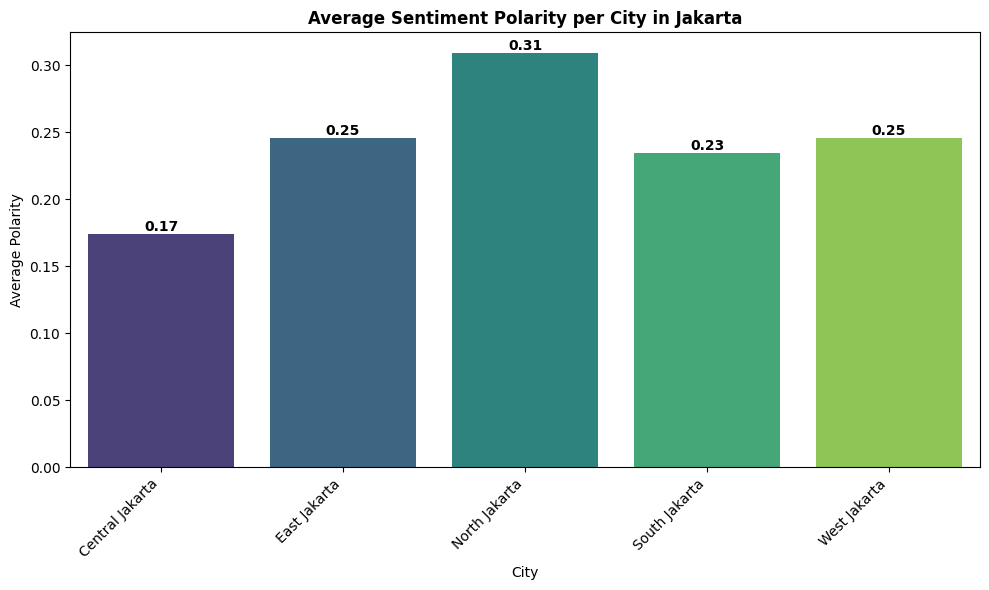

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_sentiment_per_region.index, y=average_sentiment_per_region.values, palette='viridis')
plt.title('Average Sentiment Polarity per City in Jakarta', fontweight='bold')
plt.xlabel('City')
plt.ylabel('Average Polarity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add annotations to the average sentiment bar chart
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', color='black', fontweight='bold', padding=0.1) # Format anotasi ke 2 desimal

plt.show()

## Preparing text data for frequent word analysis

In [ ]:
# Filter DataFrames by sentiment
df_positive_reviews = df_reviews[df_reviews['Sentiment'] == 'Positive']
df_negative_reviews = df_reviews[df_reviews['Sentiment'] == 'Negative']
df_neutral_reviews = df_reviews[df_reviews['Sentiment'] == 'Neutral']

# Concatenate review texts for each sentiment
positive_reviews_corpus = ' '.join(df_positive_reviews['Teks Review'].tolist())
negative_reviews_corpus = ' '.join(df_negative_reviews['Teks Review'].tolist())
neutral_reviews_corpus = ' '.join(df_neutral_reviews['Teks Review'].tolist())

print(f"Length of positive review corpus: {len(positive_reviews_corpus)}")
print(f"Length of negative review corpus: {len(negative_reviews_corpus)}")
print(f"Length of neutral review corpus: {len(neutral_reviews_corpus)}")

Length of positive review corpus: 63808
Length of negative review corpus: 22482
Length of neutral review corpus: 45078


## Frequent Word Analysis

Import the necessary libraries, download NLTK stop words, define a text-cleaning function, and then apply this function to tokenize and clean the sentiment corpus. After that, count the most frequent words.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string

# Download NLTK resources if not already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Attempt to download punkt_tab explicitly as a workaround
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    try:
        nltk.download('punkt_tab')
    except Exception as e:
        print(f"Tidak bisa download punkt_tab: {e}")
        # Proceed without punkt_tab if download fails


def clean_text(text):
    """Convert text to lowercase, remove punctuation, and remove stop words"""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return cleaned_tokens

# Tokenize and clean the sentiment corpora
try:
    positive_tokens = clean_text(positive_reviews_corpus)
    negative_tokens = clean_text(negative_reviews_corpus)
    neutral_tokens = clean_text(neutral_reviews_corpus)

    # Count word frequencies for each sentiment
    positive_word_freq = Counter(positive_tokens)
    negative_word_freq = Counter(negative_tokens)
    neutral_word_freq = Counter(neutral_tokens)

    print("Word frequency analysis of positive, negative, and neutral reviews")
    print("\nTop 10 most frequent words in positive reviews:")
    print(positive_word_freq.most_common(10))
    print("\nTop 10 most frequent words in negative reviews:")
    print(negative_word_freq.most_common(10))
    print("\nTop 10 most frequent words in neutral reviews:")
    print(neutral_word_freq.most_common(10))

except Exception as e:
    print(f"An error occurred during text processing: {e}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Word frequency analysis of positive, negative, and neutral reviews

Top 10 most frequent words in positive reviews:
[('good', 247), ('place', 142), ('indomaret', 133), ('ok', 122), ('nice', 117), ('parking', 101), ('coffee', 76), ('friendly', 65), ('service', 64), ('shop', 61)]

Top 10 most frequent words in negative reviews:
[('indomaret', 39), ('cashier', 38), ('service', 27), ('small', 23), ('dont', 22), ('bad', 22), ('like', 21), ('said', 19), ('parking', 18), ('really', 16)]

Top 10 most frequent words in neutral reviews:
[('indomaret', 93), ('store', 63), ('parking', 60), ('cashier', 55), ('like', 38), ('atm', 35), ('one', 34), ('coffee', 34), ('place', 34), ('service', 33)]


/tmp/ipython-input-21-895400735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_positive = sns.barplot(x=[word for word, freq in positive_word_freq.most_common(10)],


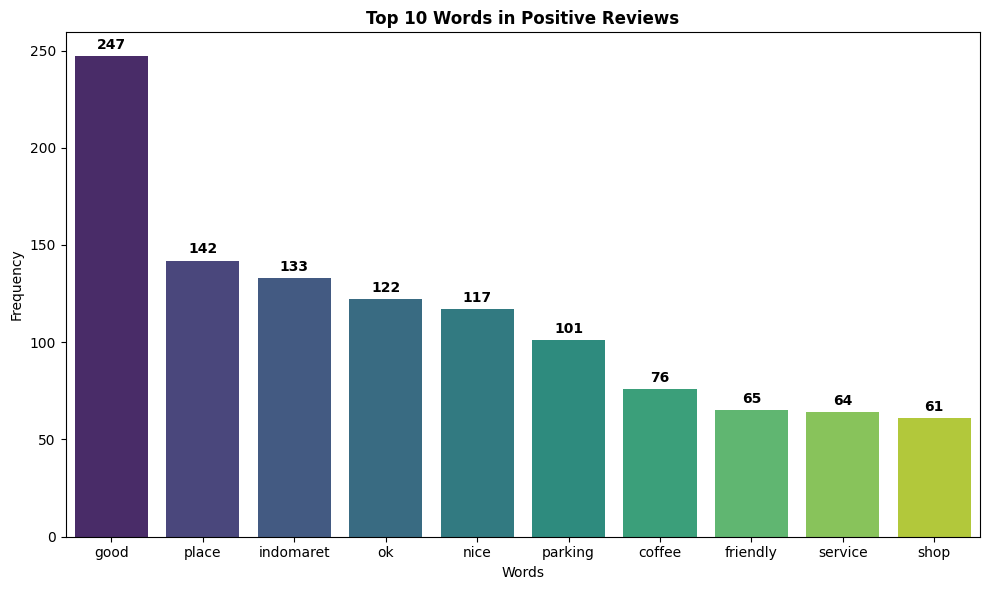

/tmp/ipython-input-21-895400735.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_negative = sns.barplot(x=[word for word, freq in negative_word_freq.most_common(10)],


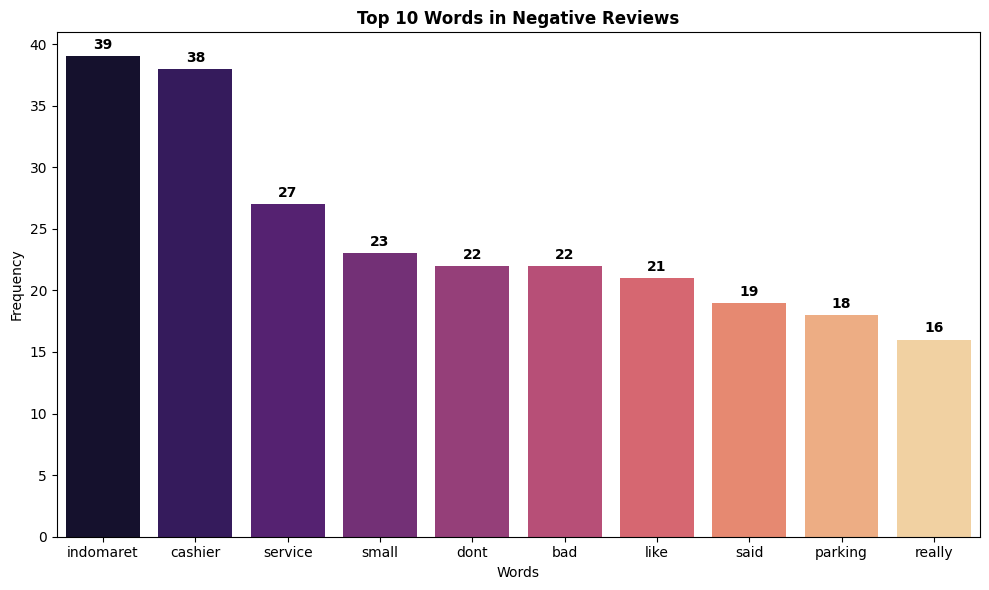

/tmp/ipython-input-21-895400735.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_neutral = sns.barplot(x=[word for word, freq in neutral_word_freq.most_common(10)],


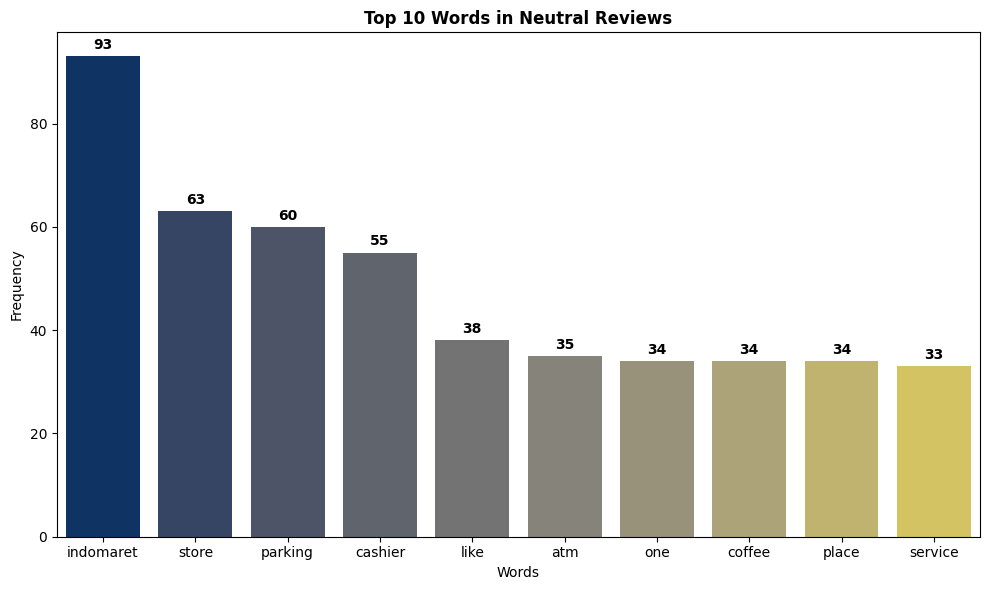

In [ ]:
# Visualize top 10 words in Positive reviews
plt.figure(figsize=(10, 6))
ax_positive = sns.barplot(x=[word for word, freq in positive_word_freq.most_common(10)],
            y=[freq for word, freq in positive_word_freq.most_common(10)], palette='viridis')
plt.title('Top 10 Words in Positive Reviews', fontweight='bold')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()

# Add annotation
for container in ax_positive.containers:
    ax_positive.bar_label(container, fmt='%d', color='black', fontweight='bold', padding=3)
plt.show()

# Visualize top 10 words in Negative reviews
plt.figure(figsize=(10, 6))
ax_negative = sns.barplot(x=[word for word, freq in negative_word_freq.most_common(10)],
            y=[freq for word, freq in negative_word_freq.most_common(10)], palette='magma')
plt.title('Top 10 Words in Negative Reviews', fontweight='bold')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()

# Add annotation
for container in ax_negative.containers:
    ax_negative.bar_label(container, fmt='%d', color='black', fontweight='bold', padding=3)
plt.show()

# Visualize top 10 words in Neutral reviews
plt.figure(figsize=(10, 6))
ax_neutral = sns.barplot(x=[word for word, freq in neutral_word_freq.most_common(10)],
            y=[freq for word, freq in neutral_word_freq.most_common(10)], palette='cividis')
plt.title('Top 10 Words in Neutral Reviews', fontweight='bold')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()

# Add annotation
for container in ax_neutral.containers:
    ax_neutral.bar_label(container, fmt='%d', color='black', fontweight='bold', padding=3)
plt.show()

## Generate word clouds


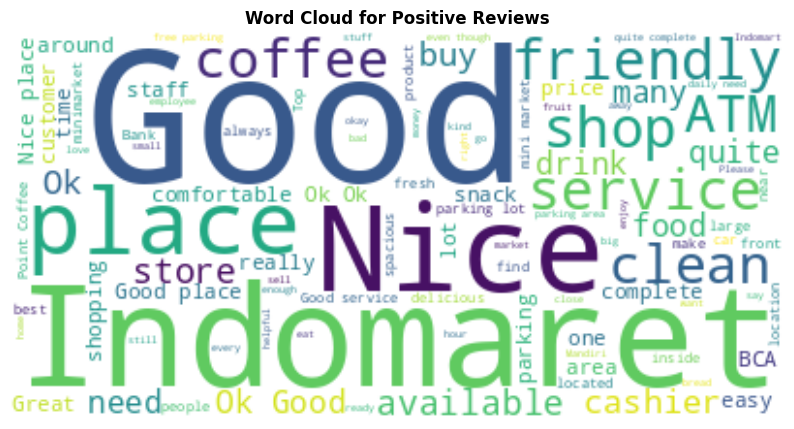

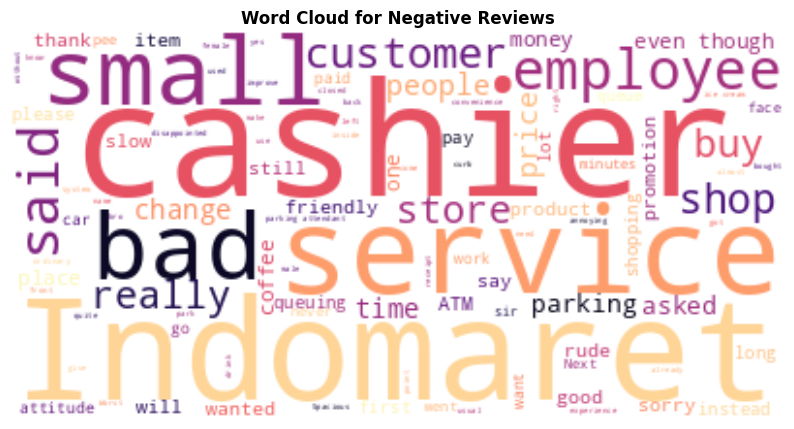

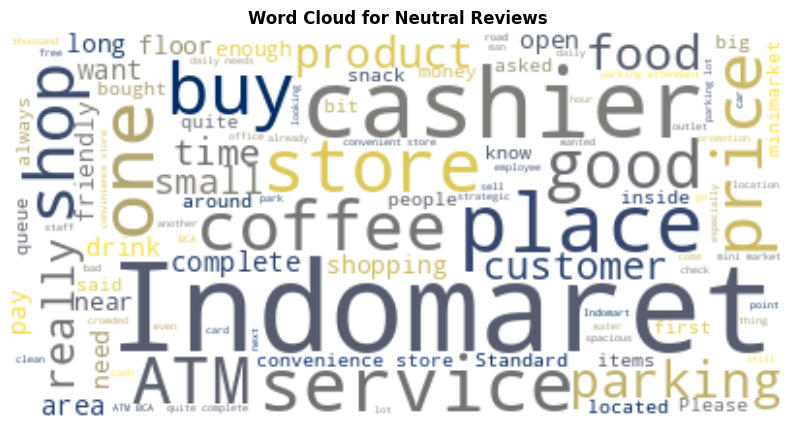

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate Word Cloud for Positive Reviews
wordcloud_positive = WordCloud(background_color='white', max_words=100).generate(positive_reviews_corpus)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Reviews', fontweight='bold')
plt.show()

# Generate Word Cloud for Negative Reviews
wordcloud_negative = WordCloud(background_color='white', max_words=100, colormap='magma').generate(negative_reviews_corpus)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Reviews', fontweight='bold')
plt.show()

# Generate Word Cloud for Neutral Reviews
wordcloud_neutral = WordCloud(background_color='white', max_words=100, colormap='cividis').generate(neutral_reviews_corpus)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Neutral Reviews', fontweight='bold')
plt.show()

# Sentiment Analysis Summary

### **Key Findings and Insights from Sentiment Analysis**

**Sentiment Distribution by Region:**  
From the analysis of average sentiment polarity per city, all regions generally show positive average polarity, although there are slight variations between cities. East Jakarta and North Jakarta show slightly higher average polarity compared to West, Central, and South Jakarta.

**Frequent Words Based on Sentiment:**

*   **Positive Reviews:** The most frequent words in positive reviews reflect favorable experiences related to facilities and location. Words like 'good', 'place', 'indomaret', 'ok', and 'nice' indicate general customer satisfaction.

*   **Negative Reviews:** Words commonly found in negative reviews are often related to staff interactions and service. 'indomaret', 'cashier' and 'service' appear as the main focus of complaints, followed by terms like 'small' and 'dont', suggesting unpleasant customer experiences.

*   **Neutral Reviews:** Words in neutral reviews tend to include terms from both categories, such as 'indomaret', 'store', 'parking', 'cashier', and 'like', indicating more objective or descriptive comments without strong emotional tone.

**Implications and Next Steps:**

1. **Staff Training:** The high frequency of the words 'cashier' and 'service' in negative reviews highlights the need to improve customer service training, particularly for cashier roles.

2. **Facility and Location Improvements:** The word "parking" appearing in both negative and neutral reviews—along with related terms like "place" and "small"—shows that comfort and facility access are important to visitors. Special attention should be given to parking availability and management. Beyond ensuring adequate parking, potential issues such as the presence of illegal parking attendants should be anticipated. It is recommended to collaborate with local authorities to create a safe and orderly environment for visitors.

3. **Store-Level Deep Dive:** Identifying stores with high negative sentiment can help management conduct targeted investigations into specific issues at those locations.

4. **Further Topic Analysis:** Applying more advanced NLP techniques (e.g., Topic Modeling) can uncover specific themes in reviews that drive positive or negative sentiment (e.g., cleanliness, product availability, promotions, etc.).

5. **More Comprehensive Data Collection:** For stronger analysis, it is recommended to gather more reviews per location, potentially from sources beyond the Google Places API.
